In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Brief Description of Dataset
This dataset is for **a text classification task in the field of Natural Language Processing**. It is a **binary classification problem** that the goal is to determine **whether a given tweet is a real disaster event or not**.  
The dataset is small with **7613 samples** in the training set with some **missing values**. I think we need to perform data cleaning before feature engineering.
Both the train and test files include **three input features — keyword, location, and text — and one target label, where 1 indicates a disaster-related tweet and 0 indicates a non-disaster tweet**.

# Training and Evaluation Strategies
In this project, I first trained a **Traditional Machine Learning model (Logistic Regression)** using **TF-IDF vectorized representations** of the tweets.
Second, I trained a model on the dataset with RNN family — including **Bidirectional GRU**, and **Bidirectional LSTM** — were implemented to capture the sequential and contextual nature of language.

Model performance was evaluated using **validation accuracy** and **F1-score** to compare the effectiveness of the traditional and deep learning.

# Import Necessary Libaries

In [2]:
import warnings
warnings.filterwarnings('ignore')

# for Data Analysis & Utilities
import pandas as pd
import numpy as np
import re, string

# for Data Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns # Heatmap, Countplot
from collections import Counter # Word Counting

# for Data Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Libraries and Tools for Baseline Model LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Libraries and Tools for RNN
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Concatenate, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras import layers, regularizers

from textblob import TextBlob

from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-10-17 00:10:53.871037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760659854.124158      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760659854.196789      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d ./glove
glove_path = './glove/glove.6B.100d.txt'

--2025-10-17 00:11:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-17 00:11:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-17 00:11:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

# Import Dataset

In [4]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print(train.shape, test.shape)
train.head()

(7613, 5) (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data Cleaning
I found that there are a lot of **symbols, user taggings, and URL strings** in the tweets, which I considered unimportant for model training. Therefore, I removed these patterns during the initial cleaning process.  
Secondly, the dataset contains some **missing values** in the location and keyword fields. These missing entries were filled with empty strings to ensure consistent input for subsequent preprocessing.

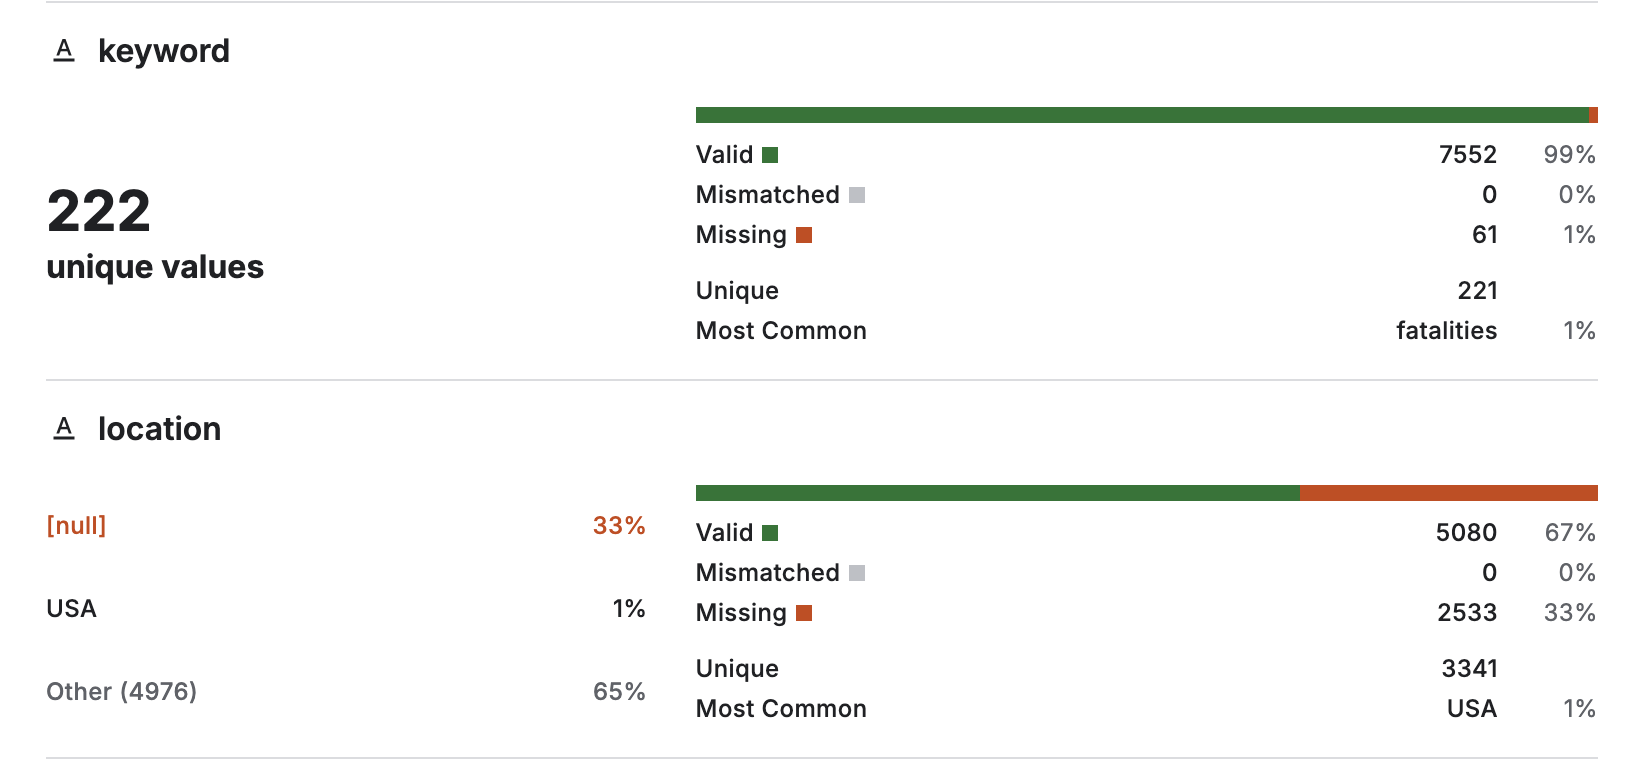

In [ ]:
# it's a function refere from kaggle's discussion page
def clean_text(text):
    # to make text consistent
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)     
    text = re.sub(r'@\w+', '', text)        # remove @user
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remove symbol
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train['text'] = train['text'].apply(clean_text)
test['text'] = test['text'].apply(clean_text)

# Fill Nan with Empty String
train['keyword'] = train['keyword'].fillna('')
test['keyword'] = test['keyword'].fillna('')

train['location'] = train['location'].fillna('')
test['location'] = test['location'].fillna('')

# Label Encode
kw_encoder = LabelEncoder()
train['keyword_enc'] = kw_encoder.fit_transform(train['keyword'])
test['keyword_enc'] = kw_encoder.transform(test['keyword'])

loc_encoder = LabelEncoder()
loc_encoder.fit(pd.concat([train['location'], test['location']], axis=0))

train['location_enc'] = loc_encoder.transform(train['location'])
test['location_enc'] = loc_encoder.transform(test['location'])

# Exploratory Data Analysis (EDA)
After data cleaning, I conducted some exploratory data analysis (EDA) to gain a better understanding of the dataset. Although it might seem unnecessary for an RNN model, it was still essential for building the baseline model.  
This analysis also inspired the idea of using the keyword field as an additional input feature for the RNN model, since the keyword feature shows a strong semantic correlation with the disaster-related content. For example, keywords such as **“wreckage,” “debris,” “derailment,” “outbreak,” and “typhoon”** are almost associated with disaster-related tweets, each showing an average disaster label close to 1.0.
In contrast, keywords like **“panicking,” “screaming,” or “aftershock”** often appear in non-disaster contexts, with average labels below 0.1.

For RNN word length selection, I also drew the word count distribution of all tweets. Most tweets contained fewer than 25 words, with a few longer outliers.

In [91]:
missing_keyword = (train['keyword'] == '').sum()
missing_location = (train['location'] == '').sum()
print(f"nan keyword count: {missing_keyword}")
print(f"nan location count: {missing_location}")

nan keyword count: 61
nan location count: 2533


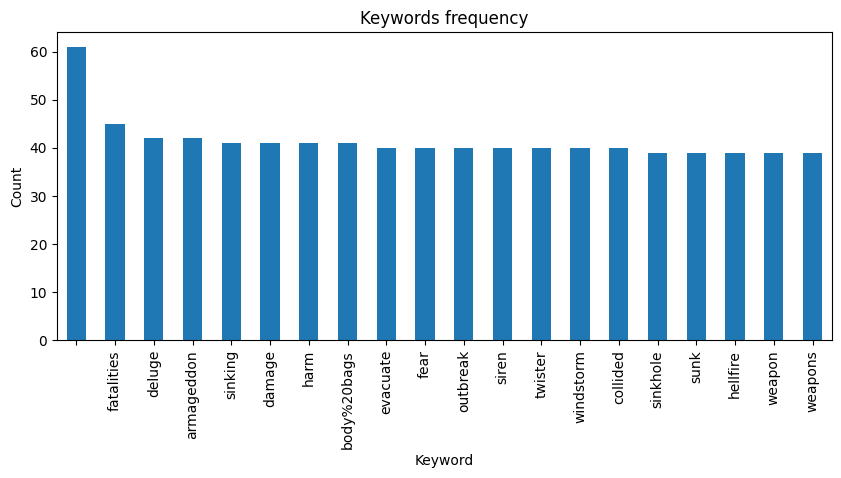

In [7]:
train['keyword'].value_counts().head(20).plot(kind='bar', figsize=(10,4))
plt.title('Keywords frequency')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.show()

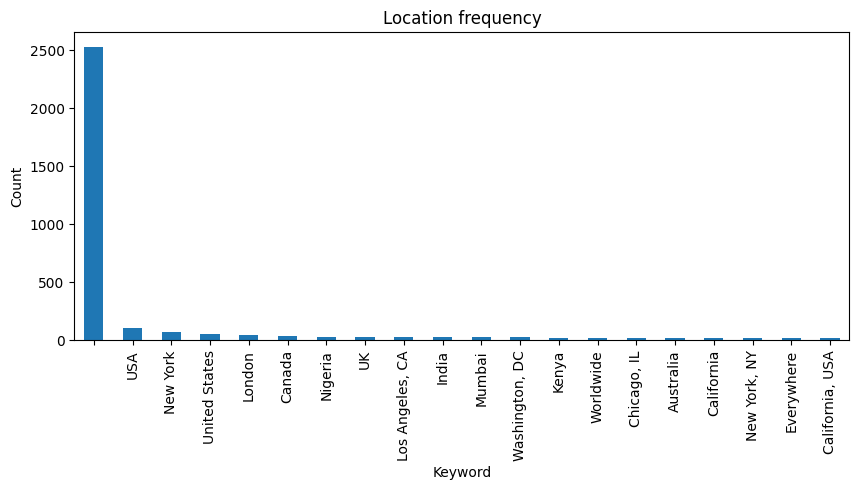

In [8]:
train['location'].value_counts().head(20).plot(kind='bar', figsize=(10,4))
plt.title('Location frequency')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.show()

In [9]:
train.groupby('keyword')['target'].mean().sort_values(ascending=False).head(10)

keyword
wreckage             1.000000
debris               1.000000
derailment           1.000000
outbreak             0.975000
oil%20spill          0.973684
typhoon              0.973684
suicide%20bombing    0.969697
suicide%20bomber     0.967742
bombing              0.931034
suicide%20bomb       0.914286
Name: target, dtype: float64

In [10]:
train.groupby('keyword')['target'].mean().sort_values(ascending=False).tail(10)

keyword
panicking      0.060606
blew%20up      0.060606
traumatised    0.057143
screaming      0.055556
electrocute    0.031250
body%20bag     0.030303
blazing        0.029412
ruin           0.027027
body%20bags    0.024390
aftershock     0.000000
Name: target, dtype: float64

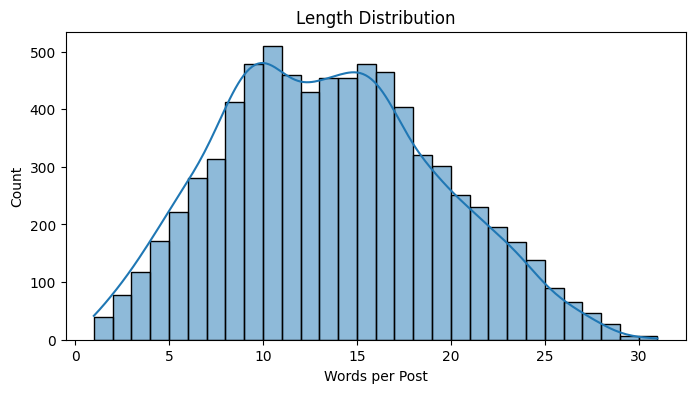

In [92]:
train['text_len'] = train['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,4))
sns.histplot(train['text_len'], bins=30, kde=True)
plt.title('Length Distribution')
plt.xlabel('Words per Post')
plt.show()

# Baseline model (Traditional ML - LogisticRegression)
For the traditional machine learning baseline, I used **TF-IDF vectorization** to represent the textual data and trained a **Logistic Regression classifier**.  
The model achieved approximately **79.5% validation accuracy** and an **F1-score of around 0.737**, demonstrating that a simple linear model can already capture a significant portion of the disaster-related semantics through word frequency patterns.  

## Feature Engineering for Traditional ML


In [93]:
vectorizer = TfidfVectorizer(max_features=5000)
X_text_vectorizer = vectorizer.fit_transform(train['text'])
X_test_text_vectorizer = vectorizer.transform(test['text'])

# Word Feature / others
X_vectorizer_enc = np.hstack((X_text_vectorizer.toarray(), train[['keyword_enc', 'location_enc']].values))
X_test_vectorizer_enc = np.hstack((X_test_text_vectorizer.toarray(), test[['keyword_enc', 'location_enc']].values))

y = train['target']

In [95]:
X_train, X_val, y_train, y_val = train_test_split(X_vectorizer_enc, y, test_size=0.2, random_state=42, stratify=y)

## Training for Traditional ML

In [76]:
model_LogisticRegression = LogisticRegression(max_iter=1000,        
                                                tol=1e-4,               
                                                solver='lbfgs',        
                                                verbose=1,              
                                                n_jobs=-1)
model_LogisticRegression.fit(X_train, y_train)

y_pred = model_LogisticRegression.predict(X_val)
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)

print('Baseline model performance')
print(f"Validation F1 Score: {f1:.4f}")
print(f"accuracy: {accuracy}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Baseline model performance
Validation F1 Score: 0.7376
accuracy: 0.7955665024630542


In [97]:
# use auc_score
auc_score = roc_auc_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)

print('Logistic Regression')
print(auc_score)
print(report)
print(cm)

0.7799317715999285
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       695
           1       0.82      0.67      0.74       523

    accuracy                           0.80      1218
   macro avg       0.80      0.78      0.79      1218
weighted avg       0.80      0.80      0.79      1218

[[619  76]
 [173 350]]


# Feature Engineering for RNN

## Sequence Length Selection
To determine an appropriate sequence length for the RNN model,
I first analyzed the word count distribution of all tweets. Most tweets contained fewer than 25 words, with a few longer outliers.
Therefore, I set the maximum sequence length (max_len) to the 95th percentile of tweet lengths.

In [16]:
# use 95% length as maximum sequence length
max_len = int(np.percentile(train['text_len'], 95))
print(f"max_len = {max_len}")

max_len = 23


## Tokenization
Then I do tokenization step and converts each tweet into a sequence of integer word indices.

In [17]:
MAX_WORDS = 20000
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(train['text'])

X_seq = tokenizer.texts_to_sequences(train['text'])
X_test_seq = tokenizer.texts_to_sequences(test['text'])

X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

y = train['target'].values

## Word Embeddings
Then I used the pre-trained GloVe word embeddings and builds an embedding matrix. It provides the RNN with semantic information from GloVe instead of learning word meanings from start.

In [18]:
text_input = Input(shape=(max_len,), name="text_input")

# using glove as a pretraining embeddings
embeddings_index = {}
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((MAX_WORDS, 100))
for word, i in tokenizer.word_index.items():
    if i < MAX_WORDS:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

embedding_text = Embedding(input_dim=MAX_WORDS,
                           output_dim=100,
                           weights=[embedding_matrix],
                           trainable=False,   
                           mask_zero=True)(text_input)

2025-10-17 00:19:57.048223: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


And I want to evaluate whether other features — such as keyword information and sentiment—can improve the model’s ability to classify disaster-related tweets.
So I compute the sentiment polarity score for each tweet using TextBlob and combines it with the encoded keyword feature.

In [19]:
# Sentiment Score
train['sentiment'] = train['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['sentiment'] = test['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Keyword Standardization
scaler = StandardScaler()
train_extra_keyword = scaler.fit_transform(train[['keyword_enc', 'sentiment']])
test_extra_keyword = scaler.transform(test[['keyword_enc', 'sentiment']])

In [22]:
# all data input for RNN
X_train_pad, X_val_pad, X_train_extra_keyword, X_val_extra_keyword, y_train, y_val = train_test_split(
    X_pad, train_extra_keyword, y, test_size=0.2, random_state=42, stratify=y
)

print('Train:', np.bincount(y_train))
print('Val:', np.bincount(y_val))


Train: [2778 2094]
Val: [695 523]


In [61]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)

# RNN (Bidirectional GRU)
I developed a **Bidirectional GRU** to train the model because I want to see whether capture both forward and backward contextual dependencies is useful for training in the tweet text.

In [62]:
from tensorflow.keras.layers import Attention, GlobalAveragePooling1D, Reshape

rnn_out = Bidirectional(GRU(48, dropout=0.3, recurrent_dropout=0.3))(embedding_text)
rnn_out = Dropout(0.5)(rnn_out) 

x = Dense(32, activation='relu')(rnn_out)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model_Bidirectional_GRU = Model(inputs=text_input, outputs=output)
model_Bidirectional_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_Bidirectional_GRU.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 23, 100)   │  2,000,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 23)        │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 96)        │     43,200 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 96)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      3,104 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         33 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,046,337 (7.81 MB)

 Trainable params: 46,337 (181.00 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [63]:
history_Bidirectional_GRU = model_Bidirectional_GRU.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=5,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.5719 - loss: 0.6832 - val_accuracy: 0.7521 - val_loss: 0.5427 - learning_rate: 0.0010
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7067 - loss: 0.5704 - val_accuracy: 0.7718 - val_loss: 0.4816 - learning_rate: 0.0010
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7491 - loss: 0.5217 - val_accuracy: 0.7939 - val_loss: 0.4545 - learning_rate: 0.0010
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7726 - loss: 0.5017 - val_accuracy: 0.7980 - val_loss: 0.4345 - learning_rate: 0.0010
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7764 - loss: 0.4886 - val_accuracy: 0.8013 - val_loss: 0.4283 - learning_rate: 0.0010


# RNN (Bidirectional LSTM)
This model shares the same architecture and hyperparameters as the Bidirectional GRU model, except that the recurrent layer is replaced with a **Bidirectional LSTM**. I want to compare the performance differences between GRU and LSTM units on the disaster tweet classification task.

In [65]:
rnn_out = Bidirectional(LSTM(48, dropout=0.3, recurrent_dropout=0.3))(embedding_text)
rnn_out = Dropout(0.5)(rnn_out)  

x = Dense(32, activation='relu')(rnn_out)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model_Bidirectional_LSTM = Model(inputs=text_input, outputs=output)
model_Bidirectional_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_Bidirectional_LSTM.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 23, 100)   │  2,000,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 23)        │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 96)        │     57,216 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 96)        │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      3,104 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         33 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,060,353 (7.86 MB)

 Trainable params: 60,353 (235.75 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [66]:
history_Bidirectional_LSTM = model_Bidirectional_LSTM.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=5,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - accuracy: 0.5794 - loss: 0.6695 - val_accuracy: 0.7718 - val_loss: 0.4918 - learning_rate: 0.0010
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7510 - loss: 0.5298 - val_accuracy: 0.7939 - val_loss: 0.4552 - learning_rate: 0.0010
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7566 - loss: 0.5145 - val_accuracy: 0.7898 - val_loss: 0.4381 - learning_rate: 0.0010
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7837 - loss: 0.4892 - val_accuracy: 0.8030 - val_loss: 0.4348 - learning_rate: 0.0010
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7866 - loss: 0.4757 - val_accuracy: 0.7939 - val_loss: 0.4240 - learning_rate: 0.0010


# RNN (Bidirectional GRU with one more dense layer about keyword, sentiment score)
I used an additional input branch for including non-text features such as the encoded **keyword** and **sentiment score**.
These features are processed through a small dense layer and concatenated with the RNN output, allowing the model to learn from both textual and structured information.

In [67]:
# extra feature input 
extra_input = Input(shape=(2,), name='extra_input')
x_extra = Dense(16, activation='relu')(extra_input)

rnn_out = Bidirectional(GRU(48, dropout=0.3, recurrent_dropout=0.3))(embedding_text)
rnn_out = Dropout(0.5)(rnn_out) 

concat = Concatenate()([rnn_out, x_extra])
x = Dense(32, activation='relu')(concat)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model_Bidirectional_GRU_Keyword = Model(inputs=[text_input, extra_input], outputs=output)
model_Bidirectional_GRU_Keyword.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_Bidirectional_GRU_Keyword.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 23, 100)   │  2,000,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 23)        │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 96)        │     43,200 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_input         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 96)        │          0 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │         48 │ extra_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 112)       │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      3,616 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         33 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,046,897 (7.81 MB)

 Trainable params: 46,897 (183.19 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [68]:
history_Bidirectional_GRU_Keyword = model_Bidirectional_GRU_Keyword.fit(
    [X_train_pad, X_train_extra_keyword],
    y_train,
    validation_data=([X_val_pad, X_val_extra_keyword], y_val),
    epochs=5,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.5996 - loss: 0.6733 - val_accuracy: 0.7504 - val_loss: 0.5322 - learning_rate: 0.0010
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7236 - loss: 0.5610 - val_accuracy: 0.7890 - val_loss: 0.4700 - learning_rate: 0.0010
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7534 - loss: 0.5199 - val_accuracy: 0.7997 - val_loss: 0.4437 - learning_rate: 0.0010
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7743 - loss: 0.4946 - val_accuracy: 0.8005 - val_loss: 0.4288 - learning_rate: 0.0010
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7713 - loss: 0.5004
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7715 - loss: 0.5002 - val_accuracy: 0.7972 - val_loss: 0.4318 - learning_rate: 0.0010


# RNN (Bidirectional LSTM with one more dense layer about keyword, sentiment score)
And I used LSTM instead of GRU for comparing the performance between Bi-GRU + Keyword and Bi-LSTM-keyword with extra features.

In [69]:
# extra feature input 
extra_input = Input(shape=(2,), name='extra_input')
x_extra = Dense(16, activation='relu')(extra_input)

rnn_out = Bidirectional(LSTM(48, dropout=0.3, recurrent_dropout=0.3))(embedding_text)
rnn_out = Dropout(0.5)(rnn_out) 

concat = Concatenate()([rnn_out, x_extra])
x = Dense(32, activation='relu')(concat)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model_Bidirectional_LSTM_Keyword = Model(inputs=[text_input, extra_input], outputs=output)
model_Bidirectional_LSTM_Keyword.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_Bidirectional_LSTM_Keyword.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 23, 100)   │  2,000,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 23)        │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 96)        │     57,216 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_input         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 96)        │          0 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 16)        │         48 │ extra_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 112)       │          0 │ dropout_8[0][0],  │
│ (Concatenate)       │                   │            │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      3,616 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         33 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,060,913 (7.86 MB)

 Trainable params: 60,913 (237.94 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [70]:
history_Bidirectional_LSTM_Keyword = model_Bidirectional_LSTM_Keyword.fit(
    [X_train_pad, X_train_extra_keyword],
    y_train,
    validation_data=([X_val_pad, X_val_extra_keyword], y_val),
    epochs=5,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.5696 - loss: 0.6764 - val_accuracy: 0.7709 - val_loss: 0.5006 - learning_rate: 0.0010
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7560 - loss: 0.5285 - val_accuracy: 0.7824 - val_loss: 0.4611 - learning_rate: 0.0010
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7857 - loss: 0.4819 - val_accuracy: 0.7906 - val_loss: 0.4391 - learning_rate: 0.0010
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7914 - loss: 0.4645 - val_accuracy: 0.7997 - val_loss: 0.4375 - learning_rate: 0.0010
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7898 - loss: 0.4675 - val_accuracy: 0.7989 - val_loss: 0.4348 - learning_rate: 0.0010


# Results, Trade-offs and Analysis
The following chart compares the performance of five models — Logistic Regression, Bi-GRU, Bi-LSTM, Bi-GRU + Keyword, and Bi-LSTM + Keyword — using validation accuracy and F1-score as evaluation metrics.  

Overall, all RNN-based models have slight better performance than the baseline Logistic Regression model.  
The baseline achieved around **0.796 accuracy** and **0.738 F1-score**, while both Bi-GRU and Bi-LSTM models reached around **0.794-0.801 accuracy** and **0.746–0.766 F1-score**. I think it's not good enough but it still indicates that sequential neural networks has potential to better capture contextual dependencies in tweets.  

Between GRU and LSTM variants, the performance is nearly identical, implying that GRU offers a similar representational capacity with lower computational cost, making it a more efficient choice for this task. So I will choose **Bi-GRU + Keyword** for tuning.

=========== Logistic Regression ===========
0.7799317715999285
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       695
           1       0.82      0.67      0.74       523

    accuracy                           0.80      1218
   macro avg       0.80      0.78      0.79      1218
weighted avg       0.80      0.80      0.79      1218

[[619  76]
 [173 350]]
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
=========== Bi-GRU ===========
0.7861507352435451
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       695
           1       0.83      0.68      0.75       523

    accuracy                           0.80      1218
   macro avg       0.81      0.79      0.79      1218
weighted avg       0.80      0.80      0.80      1218

[[621  74]
 [168 355]]
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
=========== Bi-LSTM ===========
0.7858274756867546
              precision    recall  f1-score   support

   

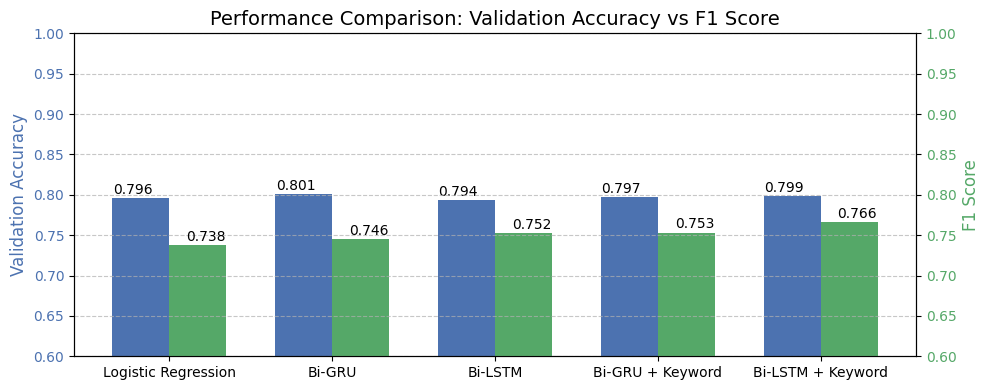

In [99]:
def show_report(name, y_val, y_pred):
    # use auc_score
    auc_score = roc_auc_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    
    print(f'=========== {name} ===========')
    print(auc_score)
    print(report)
    print(cm)
    
acc_LogisticRegression = accuracy
acc_GRU = history_Bidirectional_GRU.history['val_accuracy'][-1]
acc_LSTM = history_Bidirectional_LSTM.history['val_accuracy'][-1]
acc_GRU_keyword = history_Bidirectional_GRU_Keyword.history['val_accuracy'][-1]
acc_LSTM_keyword = history_Bidirectional_LSTM_Keyword.history['val_accuracy'][-1]

f1_LogisticRegression = f1
show_report('Logistic Regression', y_val, y_pred)

y_pred_val = (model_Bidirectional_GRU.predict(X_val_pad) > 0.5).astype(int)
f1_GRU = f1_score(y_val, y_pred_val)
show_report('Bi-GRU', y_val, y_pred_val)

y_pred_val = (model_Bidirectional_LSTM.predict(X_val_pad) > 0.5).astype(int)
f1_LSTM = f1_score(y_val, y_pred_val)
show_report('Bi-LSTM', y_val, y_pred_val)

y_pred_val = (model_Bidirectional_GRU_Keyword.predict([X_val_pad, X_val_extra_keyword]) > 0.5).astype(int)
f1_GRU_keyword = f1_score(y_val, y_pred_val)
show_report('Bi-GRU + Keyword', y_val, y_pred_val)

y_pred_val = (model_Bidirectional_LSTM_Keyword.predict([X_val_pad, X_val_extra_keyword]) > 0.5).astype(int)
f1_LSTM_keyword = f1_score(y_val, y_pred_val)
show_report('Bi-LSTM + Keyword', y_val, y_pred_val)

models = ['Logistic Regression','Bi-GRU','Bi-LSTM','Bi-GRU + Keyword','Bi-LSTM + Keyword']
accuracies = [acc_LogisticRegression,acc_GRU,acc_LSTM,acc_GRU_keyword,acc_LSTM_keyword]
f1_scores = [f1_LogisticRegression,f1_GRU,f1_LSTM,f1_GRU_keyword,f1_LSTM_keyword]

show_report('Logistic Regression', y_val, y_pred)

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10,4))

bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', color='#4C72B0')
ax1.set_ylabel('Validation Accuracy', color='#4C72B0', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#4C72B0')
ax1.set_ylim(0.6, 1.0)

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, f1_scores, width, label='F1 Score', color='#55A868')
ax2.set_ylabel('F1 Score', color='#55A868', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#55A868')
ax2.set_ylim(0.6, 1.0)

plt.xticks(x, models, rotation=20)
plt.title('Performance Comparison: Validation Accuracy vs F1 Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2 - 0.05, yval + 0.005, f"{yval:.3f}", ha='center')

for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2 + 0.05, yval + 0.005, f"{yval:.3f}", ha='center')

fig.tight_layout()
plt.show()


In [78]:
pred_test = model_LogisticRegression.predict(X_test_vectorizer_enc)
pred_test = (pred_test > 0.5).astype(int)

submission = pd.DataFrame({'id': test['id'],'target': pred_test.ravel()})
submission.to_csv('test_submission_LogisticRegression.csv', index=False)
print('test_submission_LogisticRegression.csv generated！')

test_submission_LogisticRegression.csv generated！


In [79]:
pred_test = model_Bidirectional_GRU.predict(X_test_pad)
pred_test = (pred_test > 0.5).astype(int)

submission = pd.DataFrame({'id': test['id'],'target': pred_test.ravel()})
submission.to_csv('test_submission_Bidirectional_GRU.csv', index=False)
print('test_submission_Bidirectional_GRU.csv generated！')

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
test_submission_Bidirectional_GRU.csv generated！


In [80]:
pred_test = model_Bidirectional_LSTM.predict(X_test_pad)
pred_test = (pred_test > 0.5).astype(int)

submission = pd.DataFrame({'id': test['id'],'target': pred_test.ravel()})
submission.to_csv('test_submission_Bidirectional_LSTM.csv', index=False)
print('test_submission_Bidirectional_LSTM.csv generated！')

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
test_submission_Bidirectional_LSTM.csv generated！


In [81]:
pred_test = model_Bidirectional_GRU_Keyword.predict([X_test_pad, test_extra_keyword])
pred_test = (pred_test > 0.5).astype(int)

submission = pd.DataFrame({'id': test['id'],'target': pred_test.ravel()})
submission.to_csv('test_submission_Bidirectional_GRU_Keyword.csv', index=False)
print('test_submission_Bidirectional_GRU_Keyword.csv generated！')

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
test_submission_Bidirectional_GRU_Keyword.csv generated！


In [82]:
pred_test = model_Bidirectional_LSTM_Keyword.predict([X_test_pad, test_extra_keyword])
pred_test = (pred_test > 0.5).astype(int)

submission = pd.DataFrame({'id': test['id'],'target': pred_test.ravel()})
submission.to_csv('test_submission_Bidirectional_LSTM_Keyword.csv', index=False)
print('test_submission_Bidirectional_LSTM_Keyword.csv generated！')

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
test_submission_Bidirectional_LSTM_Keyword.csv generated！


# RNN Tuning
The hyperparameter tuning for the Bi-GRU + Keyword model was performed using RandomSearch. 

In [ ]:
def build_model(hp):
    # Text input
    text_input = Input(shape=(max_len,), name='text_input')

    # Embedding 
    embedding_text = Embedding(
        input_dim=MAX_WORDS,
        output_dim=100,
        weights=[embedding_matrix],
        trainable=hp.Boolean('trainable_embedding', default=False),
        mask_zero=True
    )(text_input)

    # RNN layer
    rnn_units = hp.Choice('rnn_units', values=[32, 48, 64, 72, 96])
    dropout_rate = hp.Choice('dropout_rate', values=[0.2, 0.4, 0.6, 0.8])
    x = SpatialDropout1D(0.4)(embedding_text)

    rnn_out = Bidirectional(
        GRU(rnn_units, dropout=dropout_rate, recurrent_dropout=0.4)
    )(x)

    rnn_out = Dropout(0.6)(rnn_out) 

    # Extra input (keyword + sentiment)
    extra_input = Input(shape=(2,), name='extra_input')
    x_extra = Dense(
        hp.Choice('extra_dense_units', values=[8, 16, 32, 64, 72, 96]),
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)
    )(extra_input)

    # Concatenate both branches
    concat = Concatenate()([rnn_out, x_extra])
    x = Dense(
        hp.Choice('dense_units', values=[16, 32, 64, 128]),
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)
    )(concat)
    x = Dropout(hp.Float('dense_dropout', 0.3, 0.6, step=0.1))(x)
    output = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(x)

    # Define model
    model = Model(inputs=[text_input, extra_input], outputs=output)
    # model = Model(inputs=text_input, outputs=output)

    # Optimizer with tunable learning rate
    lr = hp.Float('learning_rate', 1e-4, 5e-4, sampling='log')
    optimizer = Adam(learning_rate=lr)

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,            
    executions_per_trial=1,
    directory='tuner_dir_4',
    project_name='BiGRU_keyword_tuning'
)

tuner.search(
    [X_train_pad, X_train_extra_keyword],
    y_train,
    validation_data=([X_val_pad, X_val_extra_keyword], y_val),
    epochs=10,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop, reduce_lr],
)

# print(tuner.results_summary())
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print('Best hyperparameters found:')
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

history_best = best_model.fit(
    [X_train_pad, X_train_extra_keyword],
    y_train,
    validation_data=([X_val_pad, X_val_extra_keyword], y_val),
    epochs=5,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)


Trial 10 Complete [00h 01m 09s]
val_accuracy: 0.6954023241996765

Best val_accuracy So Far: 0.7963874936103821
Total elapsed time: 00h 10m 35s

 Best hyperparameters found:
trainable_embedding: True
rnn_units: 48
dropout_rate: 0.4
extra_dense_units: 72
dense_units: 64
dense_dropout: 0.5
learning_rate: 0.00048684111491709863
Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.7688 - loss: 0.5103 - val_accuracy: 0.7947 - val_loss: 0.4465 - learning_rate: 4.8684e-04
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.7759 - loss: 0.5082 - val_accuracy: 0.7972 - val_loss: 0.4452 - learning_rate: 4.8684e-04
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7801 - loss: 0.4911 - val_accuracy: 0.8005 - val_loss: 0.4449 - learning_rate: 4.8684e-04
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7950 - loss: 0.4814 - val_accuracy: 0.7989 - val_loss: 0.4429 - learning_rate: 4.8684e-04
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accur

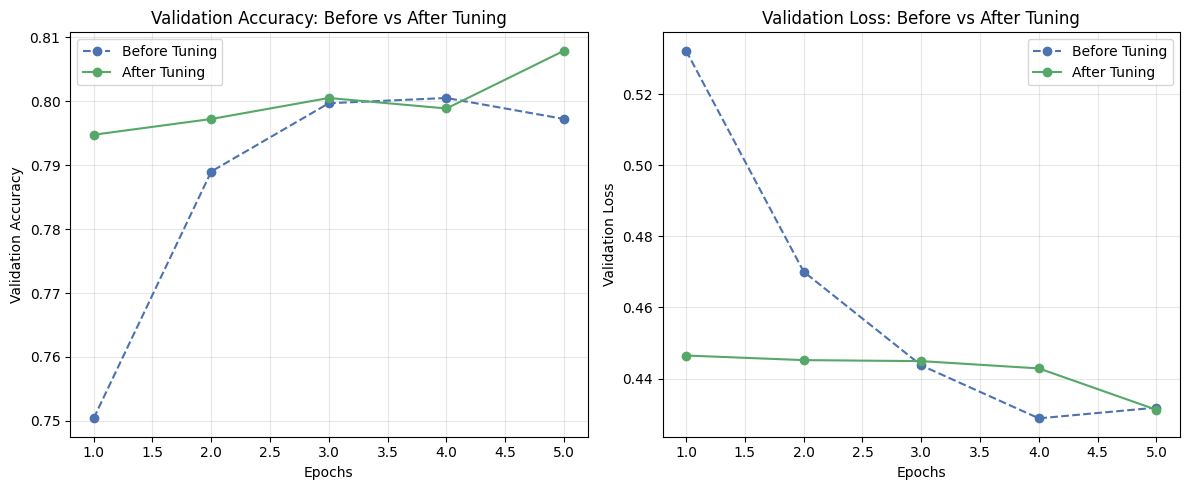

In [ ]:
acc_before = history_Bidirectional_GRU_Keyword.history['val_accuracy']
loss_before = history_Bidirectional_GRU_Keyword.history['val_loss']

acc_after = history_best.history['val_accuracy']
loss_after = history_best.history['val_loss']

epochs_before = range(1, len(acc_before) + 1)
epochs_after = range(1, len(acc_after) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_before, acc_before, 'o--', color='#4C72B0', label='Before Tuning')
plt.plot(epochs_after, acc_after, 'o-', color='#55A868', label='After Tuning')
plt.title('Validation Accuracy: Before vs After Tuning')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(epochs_before, loss_before, 'o--', color='#4C72B0', label='Before Tuning')
plt.plot(epochs_after, loss_after, 'o-', color='#55A868', label='After Tuning')
plt.title('Validation Loss: Before vs After Tuning')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


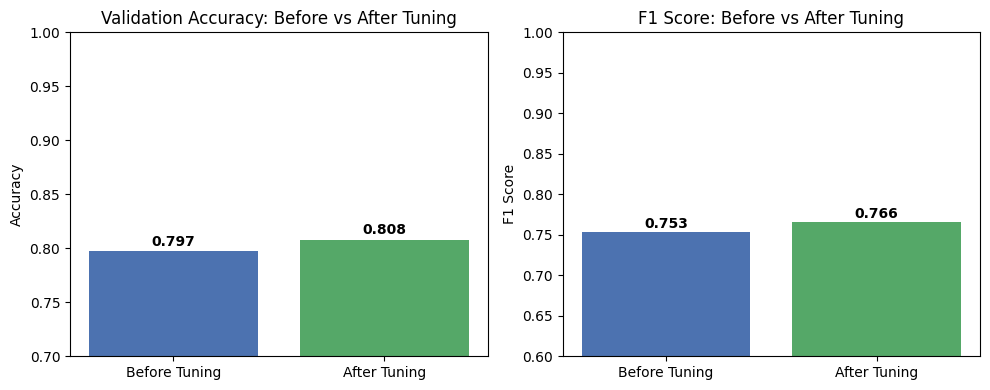

In [ ]:
acc_best = history_best.history['val_accuracy'][-1] 
y_pred_val = (best_model.predict([X_val_pad, X_val_extra_keyword]) > 0.5).astype(int) 
f1_best = f1_score(y_val, y_pred_val)

models = ['Before Tuning', 'After Tuning']
accuracies = [acc_GRU_keyword, acc_best]
f1_scores = [f1_GRU_keyword, f1_best]

fig, ax1 = plt.subplots(1, 2, figsize=(10, 4))

ax1[0].bar(models, accuracies, color=['#4C72B0', '#55A868'])
ax1[0].set_title('Validation Accuracy: Before vs After Tuning')
ax1[0].set_ylim(0.7, 1.0)
ax1[0].set_ylabel('Accuracy')
for i, v in enumerate(accuracies):
    ax1[0].text(i, v + 0.005, f"{v:.3f}", ha='center', fontweight='bold')

ax1[1].bar(models, f1_scores, color=['#4C72B0', '#55A868'])
ax1[1].set_title('F1 Score: Before vs After Tuning')
ax1[1].set_ylim(0.6, 1.0)
ax1[1].set_ylabel('F1 Score')
for i, v in enumerate(f1_scores):
    ax1[1].text(i, v + 0.005, f"{v:.3f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [90]:
pred_test = best_model.predict([X_test_pad, test_extra_keyword])
pred_test = (pred_test > 0.5).astype(int)

submission = pd.DataFrame({
    'id': test['id'],
    'target': pred_test.ravel()
})
submission.to_csv('test_submission_best.csv', index=False)
print('test_submission_best.csv generated！')

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
test_submission_best.csv generated！


# Conclution
The figure below compares the validation performance before and after hyperparameter tuning using RandomSearch.
After tuning, the Bi-GRU + Keyword model achieved slightly higher validation accuracy and a more stable loss curve, but not to much. 

Compared to the untuned baseline, the tuned model achieved:  
Validation Accuracy: +1% improvement (≈0.797 → ≈0.808)  

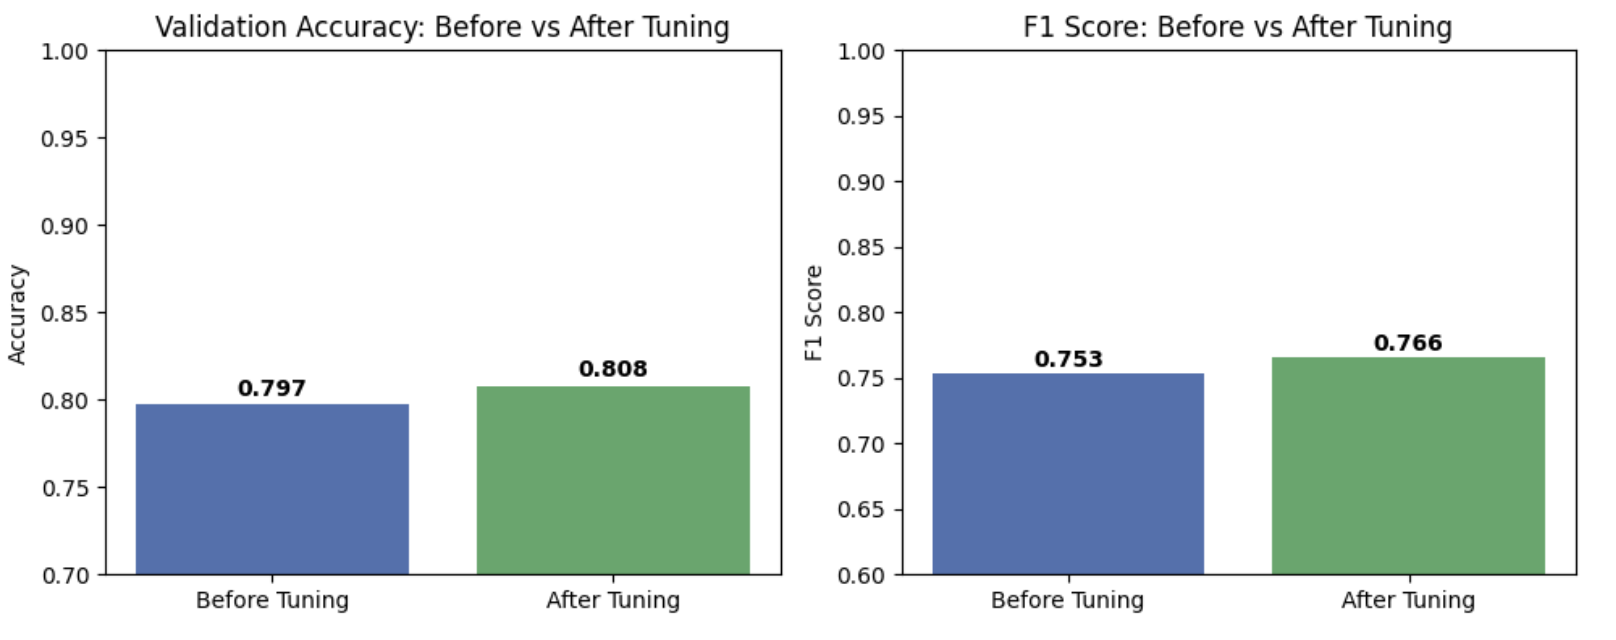

In summary, I conduct a table showes the model evolution from the traditional Logistic Regression baseline to the deep learning models. 
When switching to RNN, both Bi-GRU and Bi-LSTM slightly improved the performance, benefiting from sequential context learning.
Adding the keyword, sentiment feature provided a modest boost in F1, with the Bi-LSTM + Keyword model achieving the best overall performance. Considering that GRU offers a similar representational capacity with lower computational cost, I choose **Bi-GRU + Keyword** for tuning. 

After hyperparameter tuning, the Bi-GRU + Keyword (Tuning) model’s performance increase slightly, but not too much, suggesting possible overfitting or unstable parameter search due to the small dataset size.

# Future improvements
- Expanding data diversity with NLP data augmentation (synonym replacement, back translation, etc.)
- Fine-tuning pretrained embeddings or using contextual models (BERT, RoBERTa, etc.)

<div align='center'>

| model                   | accuracy             | f1-score |
|-------------------------|----------------------|------------|
| Logistic Regression     | 0.796                | 0.738      |
| Bi-GRU                  | 0.801                | 0.746      |
| Bi-LSTM                 | 0.794                | 0.752      |
| Bi-GRU  + Keyword       | 0.797                | 0.753      |
| Bi-LSTM + Keyword       | 0.799                | 0.766      |
| Bi-GRU  + Keyword Tuning| 0.808                | 0.766      |

</div>


# Reference
- [Kaggle Discussion Page](https://www.kaggle.com/competitions/nlp-getting-started/discussion/157982)
- [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)
- [Tokenization vs Embeddings](https://www.geeksforgeeks.org/nlp/tokenization-vs-embeddings/)
- [Keras Tokenizer](https://keras.io/keras_hub/api/tokenizers/tokenizer/)
- [Keras Embedding layer](https://keras.io/api/layers/core_layers/embedding/)
- [Keras RandomSearch](https://keras.io/keras_tuner/api/tuners/random/)
- [Introduction to NLP with Disaster Tweets](https://medium.com/analytics-vidhya/introduction-to-nlp-with-disaster-tweets-3b672a75748c)
- [Classification of Disaster Tweets Using Natural Language Processing Pipeline](https://www.researchgate.net/publication/370131491_Classification_of_Disaster_Tweets_Using_Natural_Language_Processing_Pipeline)